In [98]:
# Import Optimization Libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# Import General Libraries
import sympy as sym
import numpy as np
from IPython.display import display 

# Create a Concrete Model
model = ConcreteModel()

In [99]:
Nodes = 100
model.Nodes = range(Nodes)

In [100]:
model.X0 = Param(initialize = 0.0) # position of fixed base
model.Y0 = Param(initialize = 0.0)
model.h = Param(initialize = 0.02) # time step

model.Damping = Param(initialize = 0.7)  # Damping coefficient
model.mass = Param(initialize = 1.0) # mass of the 'mass'

# Initailize Position, Velocity and Acceleration
model.x1 = Var(model.Nodes)
model.dx1 = Var(model.Nodes)
model.ddx1 = Var(model.Nodes)

model.Force = Var(model.Nodes)

# Define Contact Force
model.CF_ext = Var(model.Nodes)
model.CF_rtn = Var(model.Nodes)
model.L_max = Param(initialize = 4)
model.L_min = Param(initialize = 0)

In [101]:
# Intergration Constraints
def BwEuler_p(model,n): # Positions
    if n > 1:
        return model.x1[n] == model.x1[n-1] + model.h*model.dx1[n-1]
    else:
        return Constraint.Skip # Leaves out members of a set that the constraint doesn't apply to
model.integrate_p = Constraint(model.Nodes, rule = BwEuler_p)

def BwEuler_v(model,n): # Velocities
    if n > 1:
        return model.dx1[n] == model.dx1[n-1] + model.h*model.ddx1[n-1]
    else:
        return Constraint.Skip 
model.integrate_v = Constraint(model.Nodes, rule = BwEuler_v)

In [102]:
X0 = sym.symbols('X0')   #starting position of the block
m1 = sym.symbols('m1')   #mass of the block
b1 = sym.symbols('b1')   #damping coefficient

L_max = sym.symbols('L_max')  # Max stroke length
L_min = sym.symbols('L_min')  # Min stroke length

x1 = sym.symbols('x1')                #position of the block
dx1 = sym.symbols('\dot{\\ x}_{1}')    #velocity of the block
ddx1 = sym.symbols('\ddot{\\ x}_{1}')  #acceleration of the block

q = sym.Matrix([x1])
dq = sym.Matrix([dx1])
ddq = sym.Matrix([ddx1])

Xnew = X0 + x1

p1 = sym.Matrix([Xnew, x1])
[dXnew, dx1] = p1.jacobian(q)*dq
#display(p1)             # [original position + current position ; current position]

# Just checking
dp1 = sym.Matrix([dXnew, dx1]) # --> derivative of the p1 matrix
#display(dp1)

######################################################################################################################
######################################################################################################################

#Define kinetic and potential energies for use in Lagrangian
T = sym.Matrix([0.5*m1*(dXnew**2)])
V = sym.Matrix([0]) 

# Define damping
Damp = sym.Matrix([b1*dXnew])
#display(Damp)

#Calculate terms of the Lagrangian Equation
Lg1 = sym.zeros(1,len(q))
for i in range(len(q)):
    dT_ddq = sym.diff(T,dq[i]) 
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq 

Lg3 = T.jacobian(q)

Lg4 = V.jacobian(q) 

#apply a horizontal force
F = sym.symbols('F')                  #applied force parameter
FF = sym.Matrix([[F],[0],[0]])        #force matrix
rF = sym.Matrix([[X0 + Xnew],[0],[0]])  #distance the force acts on the block
JF = rF.jacobian(q)
QF = JF.transpose()*FF
#display(QF)
Force = QF

# Complimentarity Forces
F_ext = sym.symbols('F_ext')
Extention = sym.Matrix([F_ext])
F_rtn = sym.symbols('F_rtn')
Retraction = sym.Matrix([F_rtn])

#Equation of motion
EOM = Lg1 - Lg3 + Lg4 - Damp - Force.transpose() + Retraction #- Extention
display(EOM)

Matrix([[-F + F_rtn + 1.0*\ddot{ x}_{1}*m1 - \dot{ x}_{1}*b1]])

In [103]:
# Lambdify the EOM
func_map = {'sin':sin, 'cos':cos}  
sym_list = [X0, x1, dx1, ddx1, F, m1, b1, F_ext, F_rtn]

lambEOM1 = sym.lambdify(sym_list, EOM[0], modules = [func_map])

#display(lambEOM1)

# Create EOM Constraints
def EOM1(model,n): 
    # list the model versions of all quantities in the same order as sym_list
    var_list = [model.X0, model.x1[n], model.dx1[n], model.ddx1[n], model.Force[n], model.mass, model.Damping, model.CF_ext[n], 
               model.CF_rtn[n]] 
    return lambEOM1(*var_list) == 0
model.EOM = Constraint(model.Nodes, rule = EOM1)

In [104]:
# Define Complimentarity Constraints

# Constraint Functions -->> applies a contact force when the maximum stroke length of the piston is reached, cylinder extended
                        # from rest to max displacement

# Set Epsilon 
eps = 1000

# Extention    
#def extention_contact(model,n):
#    alpha_ext = model.L_max - model.x1[n]
#    if n < Nodes:
#        return alpha_ext*model.CF_ext[n] <= eps
#    else:
#        return Constraint.Skip
#model.extention_contact = Constraint(model.Nodes, rule = extention_contact)

#model.CF_ext[Nodes-1].fixed = True
#model.CF_ext[Nodes-1].value = 0

########################################################################################################################

# Retraction 
def retraction_contact(model,n):
    alpha_rtn = model.L_min + model.x1[n]
    if n < Nodes:
        return alpha_rtn*model.CF_rtn[n] <= eps
    else:
        return Constraint.Skip
model.retraction_contact = Constraint(model.Nodes, rule = retraction_contact)    

model.CF_rtn[Nodes-1].fixed = True
model.CF_rtn[Nodes-1].value = 0

In [105]:
# Define Cost Function
def CostFunction(model):
    sum_force = 0
    for n in range(1,Nodes):
            sum_force = sum_force + model.Force[n]**2 
    return sum_force

model.Cost = Objective(rule = CostFunction)

In [106]:
# Define Variable Bounds
for n in range(1,Nodes):
    model.Force[n].setlb(-40)
    model.Force[n].setub(40)
    model.x1[n].setlb(0)
    model.x1[n].setub(50)
    # Hard stops
   # model.CF_ext[n].setlb(0)
   # model.CF_ext[n].setub(1500)
    model.CF_rtn[n].setlb(0)
    model.CF_rtn[n].setub(1500)

In [107]:
# Initialization of variables
for n in range (1,Nodes):
    model.Force[n].value = 5
    model.CF_ext[n].value = 800
    model.CF_rtn[n].value = 800
    
    model.x1[n].value = np.random.uniform(-20,20)
    model.dx1[n].value = 30
    model.ddx1[n].value = 30

In [108]:
# Set Boundary Conditions
# Initial Conditions
model.x1[1].fixed = True
model.x1[1].value = 4

model.dx1[1].fixed = True
model.dx1[1].value = 0

# Final Conditions
# Nodes-1 ensures it stops at 99, if you just say Nodes jupyter throughs a tantrum
model.x1[Nodes-1].fixed = True 
model.x1[Nodes-1].value = 0   # Stop at specified location in m

model.dx1[Nodes-1].fixed = True
model.dx1[Nodes-1].value = 0

In [109]:
# Start the Solver
for i in range (0,8):
    
    print(eps)
    optimize = SolverFactory('ipopt')

    optimize.options["print_level"] = 5
    optimize.options["max_iter"] = 30000
    optimize.options["max_cpu_time"] = 300
    optimize.options["Tol"] = 1e-6

    results = optimize.solve(model, tee = True) 
    eps = eps/10

1000
Ipopt 3.11.1: print_level=5
max_iter=30000
max_cpu_time=300
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:      980
Number of nonzeros in inequality constraint Jacobian.:      197
Number of nonzeros in Lagrangian Hessian.............:      197

Total number of variables............................:      495
                     variables with only lower bounds:        0
   

EXIT: Optimal Solution Found.
10.0
Ipopt 3.11.1: print_level=5
max_iter=30000
max_cpu_time=300
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:      980
Number of nonzeros in inequality constraint Jacobian.:      197
Number of nonzeros in Lagrangian Hessian.............:      197

Total number of variables............................:      495
                     variables with o

   0 8.0640250e+002 1.00e-002 4.38e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 8.2888278e+002 1.19e-015 3.16e-001  -1.0 3.26e-001   0.0 9.90e-001 1.00e+000h  1
   2 8.1673449e+002 9.94e-016 1.65e-001  -1.0 1.17e-001  -0.5 9.97e-001 1.00e+000f  1
   3 8.0690214e+002 1.22e-015 2.74e-002  -2.5 2.47e-001  -1.0 1.00e+000 1.00e+000f  1
   4 8.0644494e+002 1.42e-014 1.74e-001  -3.8 2.84e-001  -1.4 1.00e+000 9.21e-001f  1
   5 8.0642243e+002 1.13e-015 4.20e-002  -3.8 1.47e-001  -1.9 1.00e+000 7.60e-001f  1
   6 8.0641710e+002 7.70e-016 3.32e-004  -3.8 8.07e-002  -2.4 1.00e+000 1.00e+000f  1
   7 8.0640266e+002 1.32e-015 7.66e-005  -5.7 5.58e-002  -2.9 1.00e+000 1.00e+000f  1
   8 8.0640267e+002 9.69e-016 5.24e-006  -5.7 1.15e-002  -3.3 1.00e+000 1.00e+000h  1
   9 8.0640250e+002 1.04e-015 1.51e-007  -7.0 9.90e-004  -3.8 1.00e+000 1.00e+000f  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  8.0640249570

Number of objective gradient evaluations             = 10
Number of equality constraint evaluations            = 10
Number of inequality constraint evaluations          = 10
Number of equality constraint Jacobian evaluations   = 10
Number of inequality constraint Jacobian evaluations = 10
Number of Lagrangian Hessian evaluations             = 9
Total CPU secs in IPOPT (w/o function evaluations)   =      0.057
Total CPU secs in NLP function evaluations           =      0.002

EXIT: Optimal Solution Found.
0.0001
Ipopt 3.11.1: print_level=5
max_iter=30000
max_cpu_time=300
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipop

In [110]:
# Some debugging stuff
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.
#model.pprint()

ok
optimal


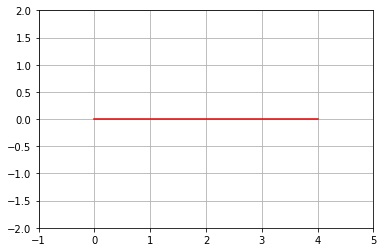

In [111]:
#animate model --> will be able to see what model is doing by viewing in with HTML
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1)
def plot_block(i,model,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,5])
    ax.set_ylim([-2,2])
    
    #plot mass
    m1topx = model.X0.value   #initial position of mass
    m1bottomx = m1topx + model.x1[i].value
    ax.plot([m1bottomx,0],[m1topx,0],color = 'xkcd:red')
  # ax.plot([m1topx,0],color = 'xkcd:red')  #plot initial block
    ax.grid(True)
    
update = lambda i: plot_block(i,model,ax1)      #lambdify just used to calculate the numerical values fast

animate = ani.FuncAnimation(fig1,update,range(1,Nodes),interval = 50, repeat = True)

#animate.save('show_me_the_money.gif', writer = 'ffmpeg')

HTML(animate.to_html5_video())